# 原始数据

In [6]:
%config InlineBackend.figure_format = 'retina'

from utils.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers import Dense, LSTM, Dropout, Activation, GRU
from keras.models import Sequential

In [1]:
ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize

timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集


x, y = get_x_y_by_sliding_window(arr, in_steps=timesteps, out_steps=1)
y = y.sum(axis=-2)  # 无论输出时间步是不是1，都要进行这项操作


x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

Using TensorFlow backend.


In [92]:
x_train.shape, x_test.shape

((2201, 7, 1), (672, 7, 1))

## 单层LSTM

In [99]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,1), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=512, validation_split=0.2, verbose=0)

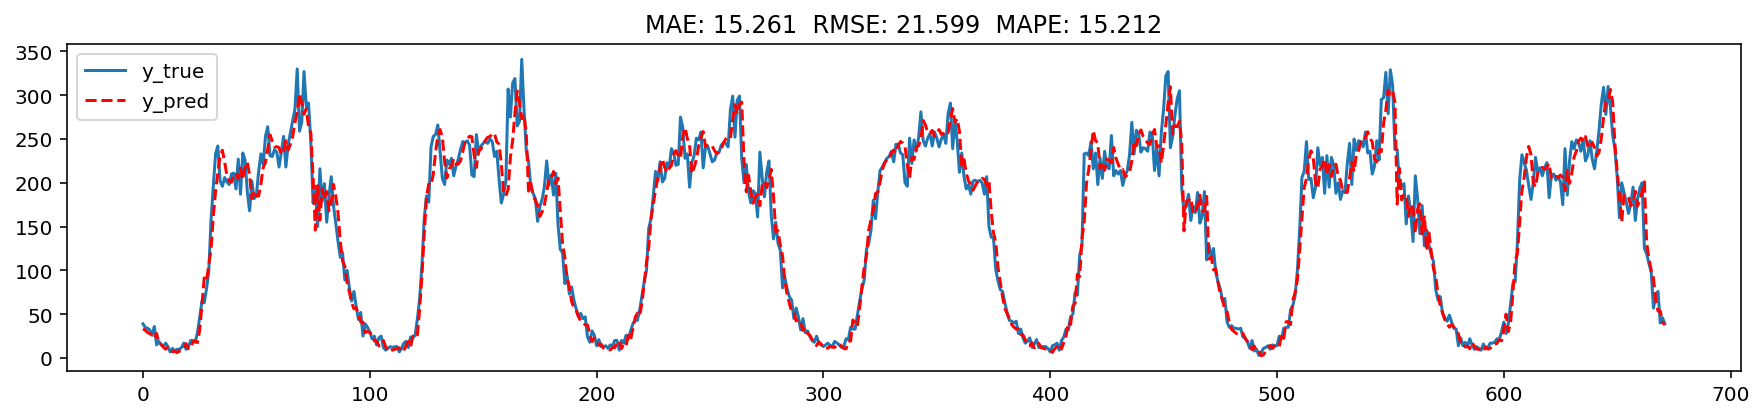

In [100]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))

## 双层LSTM

In [101]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,1),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=512, verbose=0)

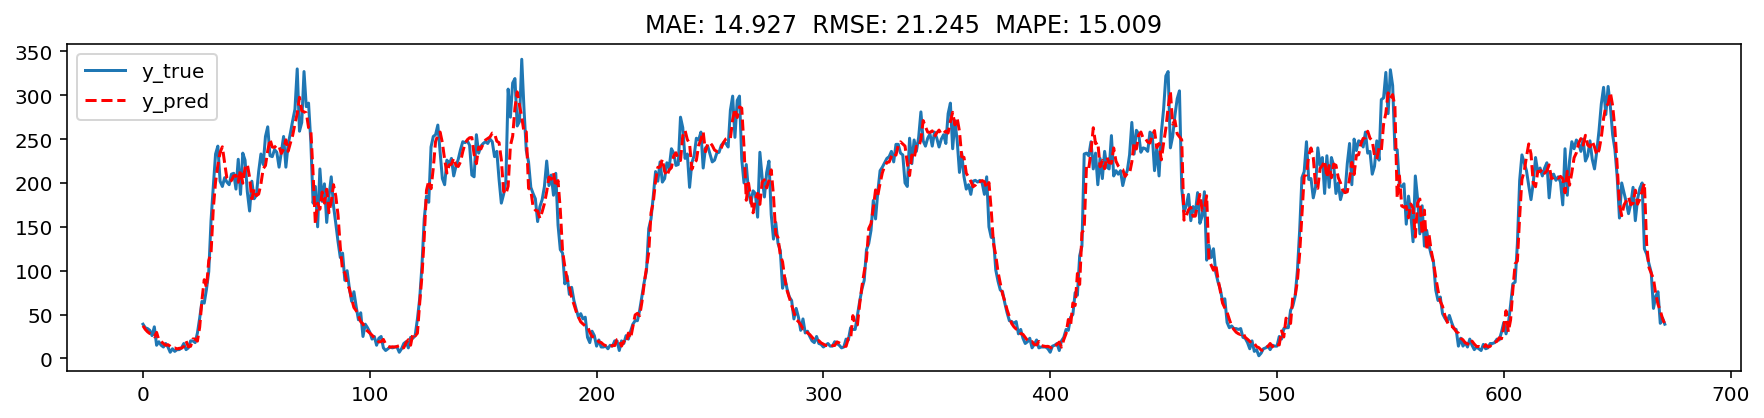

In [102]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))

双层的LSTM较单层的LSTM效果更好，接下来的测试以双层LSTM为基础

# 去趋势

## 一阶差分

In [5]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()
y_train_start = ts[timesteps]
y_test_start = ts[-test_size-1]
y_test_ts = ts[-test_size-1:-1]
ts = ts.diff(1).dropna()  # 一阶差分

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize


x, y = get_x_y_by_sliding_window(arr, in_steps=timesteps, out_steps=1)
y = y.sum(axis=-2)  # 无论输出时间步是不是1，都要进行这项操作

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [3]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,1),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=512, verbose=1)

Epoch 1/256
2200/2200 [==============================] - 1s 568us/step - loss: 1.0418
Epoch 2/256
2200/2200 [==============================] - 0s 31us/step - loss: 1.0341
Epoch 3/256
2200/2200 [==============================] - 0s 29us/step - loss: 1.0210
Epoch 4/256
2200/2200 [==============================] - 0s 29us/step - loss: 1.0098
Epoch 5/256
2200/2200 [==============================] - 0s 29us/step - loss: 1.0203
Epoch 6/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.9998
Epoch 7/256
2200/2200 [==============================] - 0s 28us/step - loss: 0.9915
Epoch 8/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.9754
Epoch 9/256
2200/2200 [==============================] - 0s 28us/step - loss: 1.0092
Epoch 10/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.9669
Epoch 11/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.9638
Epoch 12/256
2200/2200 [==============================] - 0s 2

2200/2200 [==============================] - 0s 28us/step - loss: 0.5934
Epoch 191/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.6050
Epoch 192/256
2200/2200 [==============================] - 0s 28us/step - loss: 0.6135
Epoch 193/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.5893
Epoch 194/256
2200/2200 [==============================] - ETA: 0s - loss: 0.701 - 0s 29us/step - loss: 0.6150
Epoch 195/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.5854
Epoch 196/256
2200/2200 [==============================] - 0s 28us/step - loss: 0.6137
Epoch 197/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.5862
Epoch 198/256
2200/2200 [==============================] - 0s 28us/step - loss: 0.6033
Epoch 199/256
2200/2200 [==============================] - 0s 30us/step - loss: 0.6119
Epoch 200/256
2200/2200 [==============================] - 0s 29us/step - loss: 0.6047
Epoch 201/256
2200/2200 [========

{'mae': 17.35048284011386,
 'rmse': 24.831063778617995,
 'mape': 17.557007865170725}

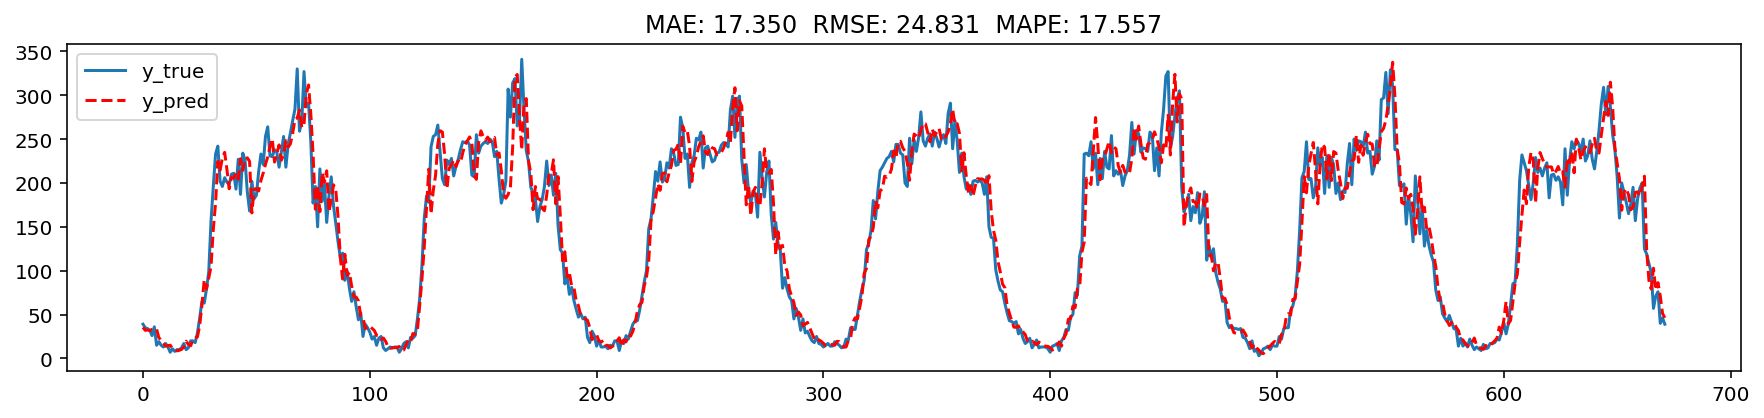

In [18]:
y_true = scaler.inverse_transform(y_test)
y_true = y_true.cumsum(axis=0) + y_test_start
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred + y_test_ts.values.reshape(-1,1)
test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))

看样子没有什么用

## 简单平均趋势（原始流量+残差->残差）

In [196]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize
ts = pd.Series(arr.reshape(-1), index=ts.index)  # 原始时间序列

df = pd.DataFrame(ts).reset_index()
df['trend_idx'] = df.datetime.apply(lambda x:str((x.weekday(),x.hour, x.minute)))
trend_df = df.iloc[0:-test_size].groupby('trend_idx').mean()  # 仅使用训练集的趋势
# trend_df = df.groupby('trend_idx').mean()
df['trend'] = df.trend_idx.apply(lambda x: trend_df.loc[x])

trend_ts = df.set_index('datetime')['trend']  # 趋势时间序列
residual_ts = ts - trend_ts  # 残差时间序列

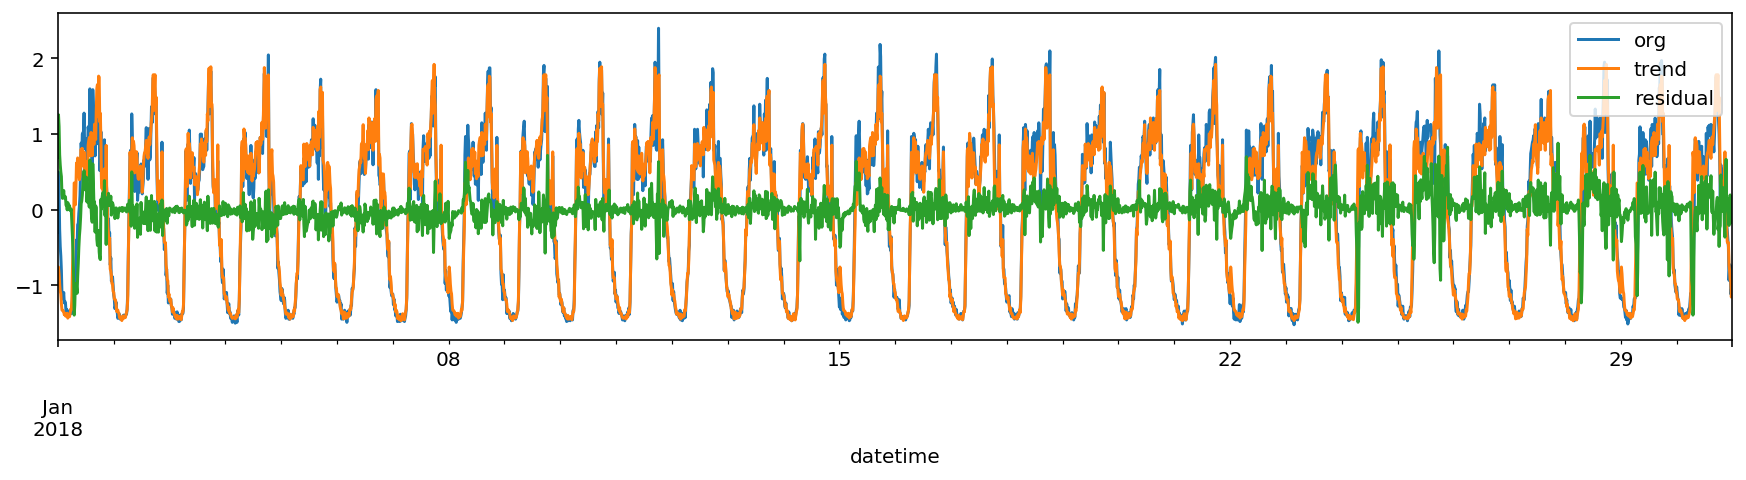

In [197]:
fig, ax = plt.subplots(figsize=(15,3))
ts.plot(ax=ax, label='org')
trend_ts.plot(ax=ax, label='trend')
residual_ts.plot(ax=ax, label='residual')
ax.legend()

In [198]:
x_trend, y_trend = get_x_y_by_sliding_window(trend_ts, in_steps=timesteps, out_steps=1)
y_trend = y_trend.sum(axis=-2)

x_residual, y_residual = get_x_y_by_sliding_window(residual_ts, in_steps=timesteps, out_steps=1)
y_residual = y_residual.sum(axis=-2)

x_org, y_org = get_x_y_by_sliding_window(ts, in_steps=timesteps, out_steps=1)
y_org = y_org.sum(axis=-2)

# x为输入时间步的原始时间序列与残差
# y为下一时刻的残差
x = np.concatenate([x_org, x_residual], axis=-1)
y = y_residual

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [199]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,2),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, verbose=0)

{'mae': 16.911399731323833,
 'rmse': 24.32634153204557,
 'mape': 16.115681077725526}

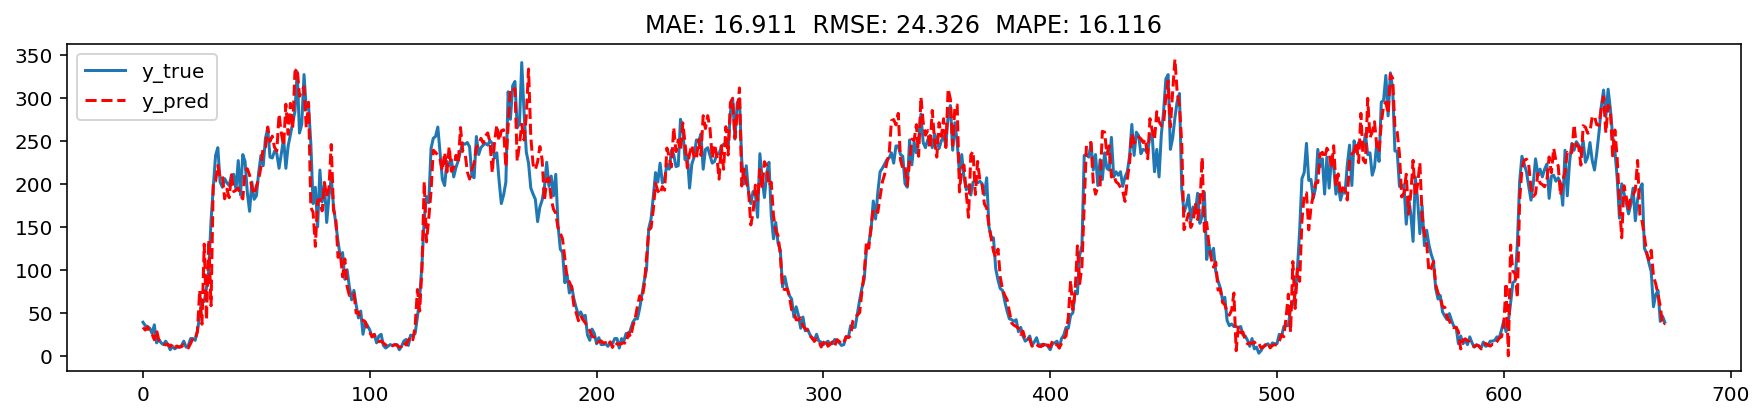

In [202]:
y_pred = model.predict(x_test)  # 残差预测值
y_pred += y_trend[-test_size:]  # 残差 + 趋势 = 时间序列
y_pred = scaler.inverse_transform(y_pred)
y_pred[y_pred<0] = 0
y_true = y_org[-test_size:]  # 时间序列真实值
y_true = scaler.inverse_transform(y_true)

test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))

## 简单平均趋势（原始流量+残差->真实流量）

In [154]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize
ts = pd.Series(arr.reshape(-1), index=ts.index)  # 原始时间序列

df = pd.DataFrame(ts).reset_index()
df['trend_idx'] = df.datetime.apply(lambda x:str((x.weekday(),x.hour, x.minute)))
trend_df = df.iloc[0:-test_size].groupby('trend_idx').mean()  # 仅使用训练集的趋势
df['trend'] = df.trend_idx.apply(lambda x: trend_df.loc[x])

trend_ts = df.set_index('datetime')['trend']

x_trend, y_trend = get_x_y_by_sliding_window(trend_ts, in_steps=timesteps, out_steps=1)
y_trend = y_trend.sum(axis=-2)

x_residual, y_residual = get_x_y_by_sliding_window(residual_ts, in_steps=timesteps, out_steps=1)
y_residual = y_residual.sum(axis=-2)

x_org, y_org = get_x_y_by_sliding_window(ts, in_steps=timesteps, out_steps=1)
y_org = y_org.sum(axis=-2)

# x为输入时间步的流量与残差
# y为下一时刻的流量
x = np.concatenate([x_org, x_residual], axis=-1)
y = y_org

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [155]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,2),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, verbose=1)

Epoch 1/256
2201/2201 [==============================] - 1s 243us/step - loss: 0.5429
Epoch 2/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.2137
Epoch 3/256
2201/2201 [==============================] - 0s 46us/step - loss: 0.1723
Epoch 4/256
2201/2201 [==============================] - 0s 46us/step - loss: 0.1695
Epoch 5/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.1606
Epoch 6/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.1305
Epoch 7/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.1508
Epoch 8/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0975
Epoch 9/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.1235
Epoch 10/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.1246
Epoch 11/256
2201/2201 [==============================] - 0s 46us/step - loss: 0.1022
Epoch 12/256
2201/2201 [==============================] - 0s 4

2201/2201 [==============================] - 0s 49us/step - loss: 0.0554
Epoch 97/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.0542
Epoch 98/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0524
Epoch 99/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.0488
Epoch 100/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0544
Epoch 101/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.0567
Epoch 102/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0526
Epoch 103/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.0512
Epoch 104/256
2201/2201 [==============================] - 0s 46us/step - loss: 0.0519
Epoch 105/256
2201/2201 [==============================] - 0s 46us/step - loss: 0.0545
Epoch 106/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.0512
Epoch 107/256
2201/2201 [==============================] - 0

2201/2201 [==============================] - 0s 49us/step - loss: 0.0410
Epoch 191/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.0397
Epoch 192/256
2201/2201 [==============================] - 0s 50us/step - loss: 0.0372
Epoch 193/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0354
Epoch 194/256
2201/2201 [==============================] - 0s 47us/step - loss: 0.0369
Epoch 195/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0419
Epoch 196/256
2201/2201 [==============================] - 0s 51us/step - loss: 0.0353
Epoch 197/256
2201/2201 [==============================] - 0s 51us/step - loss: 0.0366
Epoch 198/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0407
Epoch 199/256
2201/2201 [==============================] - 0s 50us/step - loss: 0.0356
Epoch 200/256
2201/2201 [==============================] - 0s 48us/step - loss: 0.0384
Epoch 201/256
2201/2201 [==============================] 

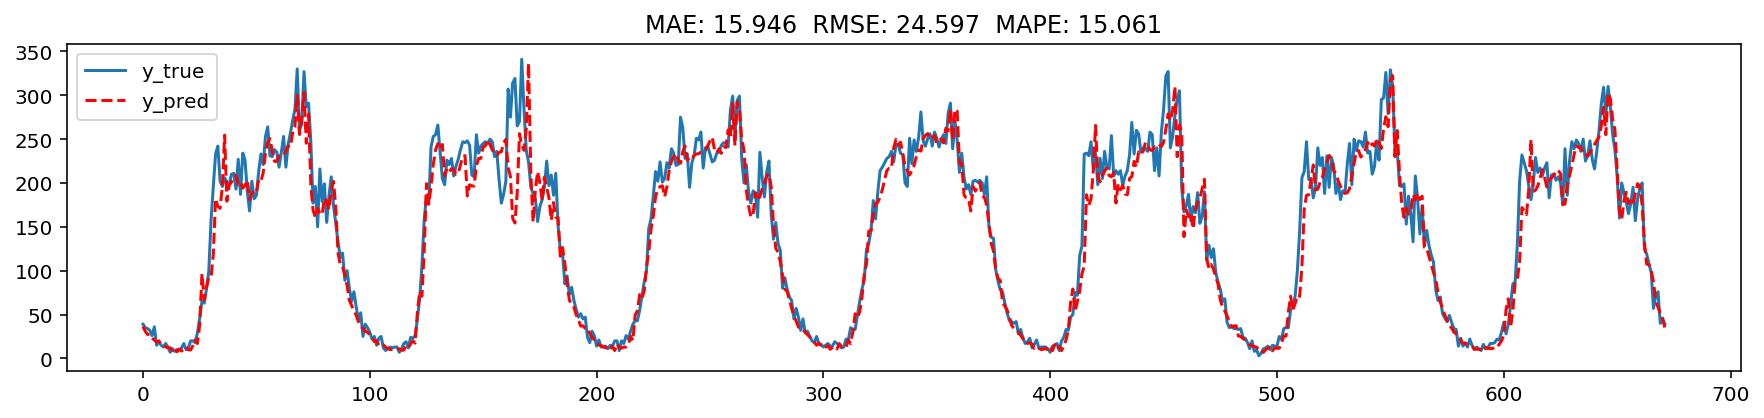

In [156]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))